# Importing Libraries and Pre-Processing

In [1]:
### Importing Libraries
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modeling libraries
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline

# Preprocessing and cross-validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, RepeatedKFold

# Model saving
import pickle

# Model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.colors import Normalize

import timeit
from datetime import timedelta

plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
### Importing and Preparing Data
# load dataset
full_train_data = pd.read_csv('train_x.csv').to_numpy()
full_train_label = pd.read_csv('train_y.csv').to_numpy().flatten()
test_data = pd.read_csv('test_x.csv').to_numpy()
test_label = pd.read_csv("test_y.csv").to_numpy().flatten()

print(f'Full train data: X = {full_train_data.shape}, y = {full_train_label.shape}')
print(f'Full test data:  X = {test_data.shape}, y = {test_label.shape}')

Full train data: X = (50000, 3072), y = (50000,)
Full test data:  X = (10000, 3072), y = (10000,)


In [3]:
# Training and Validation Set Split
train_data, val_data, train_label, val_label = train_test_split(
    full_train_data, full_train_label, test_size = 0.3, 
    stratify = full_train_label, random_state = 40)
print(f'Train data:       X = {train_data.shape}, y = {train_label.shape}')
print(f'Validation data:  X = {val_data.shape}, y = {val_label.shape}')

Train data:       X = (35000, 3072), y = (35000,)
Validation data:  X = (15000, 3072), y = (15000,)


In [4]:
# Dimensionality Reduction - PCA
pca_scaled = make_pipeline(StandardScaler(), 
                           PCA(n_components=0.8, whiten=True, random_state=0))
X_train_pca = pca_scaled.fit_transform(train_data)
X_val_pca = pca_scaled.transform(val_data)
print("PCA train data shape:      {}".format(X_train_pca.shape))
print("PCA validation data shape: {}".format(X_val_pca.shape))

PCA train data shape:      (35000, 34)
PCA validation data shape: (15000, 34)


In [5]:
# Histogram of Oriented Gradients
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

def extract_hog(data):
    fd_array = np.empty(shape=(len(data), 3780), dtype='float')
    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        fd = hog(resized_img, orientations=9, pixels_per_cell=(8,8), 
                 cells_per_block=(2,2), transform_sqrt=True, block_norm="L1")
        fd_array[i] = fd
    return fd_array

In [6]:
X_train_hog = extract_hog(train_data)
X_val_hog = extract_hog(val_data)

In [7]:
X_full_train_hog = extract_hog(full_train_data)

In [8]:
# Dimensionality Reduction - HOG-PCA
pca_scaled2 = make_pipeline(StandardScaler(), 
                           PCA(n_components=150, whiten=False, random_state=0))
X_train_hg = pca_scaled2.fit_transform(X_train_hog)
X_val_hg = pca_scaled2.transform(X_val_hog)
print("PCA train data shape:      {}".format(X_train_hg.shape))
print("PCA validation data shape: {}".format(X_val_hg.shape))

PCA train data shape:      (42500, 150)
PCA validation data shape: (7500, 150)


# Classification

### SVM

In [5]:
# GridSearch with kernel = 'rbf' using training data
param_grid1 = {'C': np.logspace(-2, 3, 6)}
svm_grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid1, cv=5, n_jobs=-1)
svm_grid.fit(X_train_pca, train_label)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [6]:
svm_results = pd.DataFrame(svm_grid.cv_results_)
print(f"best parameters:     {svm_grid.best_params_}")                    # {'C': 10.0}
print(f"Train accuracy:      {svm_grid.score(X_train_pca, train_label)}") # 0.9880941176470588
print(f"Validation accuracy: {svm_grid.score(X_val_pca, val_label)}")     # 0.554

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0     573.035780     59.444001        46.226117        3.611012    0.01   
1     492.429160     16.435071        52.833729        4.262307     0.1   
2     359.499111     52.097687        45.433052        6.351976       1   
3     572.566504     59.158784        51.121939        4.538654      10   
4     658.539254     53.078888        53.371070        4.841547     100   
5     562.790938     16.334074        46.153757        2.416183    1000   

          params  split0_test_score  split1_test_score  split2_test_score  \
0    {'C': 0.01}           0.299882           0.304235           0.306353   
1     {'C': 0.1}           0.434353           0.433059           0.441529   
2     {'C': 1.0}           0.541294           0.541765           0.552706   
3    {'C': 10.0}           0.543412           0.546235           0.560118   
4   {'C': 100.0}           0.531765           0.534353           0.538471   
5  {'C': 100

In [5]:
# Building a model with all the training and validation data and testing with test data
pca_pipe = make_pipeline(StandardScaler(), 
                           PCA(n_components=0.8, whiten=True, random_state=0))
svmod = SVC(C = 10)
svm_pipe = make_pipeline(pca_pipe, svmod)
tic = timeit.default_timer()
svm_pipe.fit(full_train_data, full_train_label)
toc = timeit.default_timer()
print(f"time elapsed: {timedelta(seconds=toc-tic)}") # 739.97 seconds 0:07:16.354765

time elapsed: 0:07:16.354765


In [6]:
print(f"Train accuracy: {svm_pipe.score(full_train_data, full_train_label)}") # 0.92318
print(f"Test accuracy:  {svm_pipe.score(test_data, test_label)}")             # 0.5313

Train accuracy: 0.92318
Test accuracy:  0.5313


In [7]:
# Model prediction
pred = svm_pipe.predict(test_data)

Accuracy: 0.531
Confusion matrix:
[[652  37  52  20  35  24  18  16 104  42]
 [ 45 637  15  29  12  19  14  20  66 143]
 [ 95  22 411  94 140  59  90  51  21  17]
 [ 35  37 104 366  63 187 105  44  17  42]
 [ 44  20 142  60 464  50 118  61  27  14]
 [ 28  17  83 210  58 419  72  65  23  25]
 [ 17  24  91  82  96  40 600  20  12  18]
 [ 41  27  56  66  86  73  34 558   7  52]
 [114  75  20  36  17  18  13  14 638  55]
 [ 45 170  22  42  15  27  12  38  61 568]]


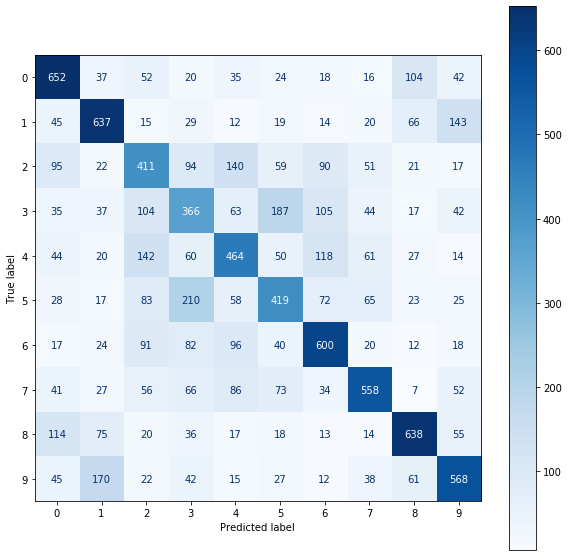

In [8]:
print(f"Accuracy: {accuracy_score(test_label, pred):.3f}")
print(f"Confusion matrix:\n{confusion_matrix(test_label, pred)}")
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(confusion_matrix(test_label, pred), 
                       display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']).plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
plt.savefig("confusion_svm.png")

In [9]:
# Classification report
print(classification_report(test_label, pred))

              precision    recall  f1-score   support

           0       0.58      0.65      0.62      1000
           1       0.60      0.64      0.62      1000
           2       0.41      0.41      0.41      1000
           3       0.36      0.37      0.37      1000
           4       0.47      0.46      0.47      1000
           5       0.46      0.42      0.44      1000
           6       0.56      0.60      0.58      1000
           7       0.63      0.56      0.59      1000
           8       0.65      0.64      0.65      1000
           9       0.58      0.57      0.57      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000



In [10]:
# Save model file with pickle
svm_pickle = "Pickle_SVM.pkl"  

with open(svm_pickle, 'wb') as file:  
    pickle.dump(svm_pipe, file)

In [5]:
# Load model from file with pickle
svm_pickle = "Pickle_SVM.pkl" 
with open(svm_pickle, 'rb') as file:  
    pickled_svm = pickle.load(file)

pickled_svm

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('standardscaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=100, random_state=0,
                                      svd_solver='auto', tol=0.0,
                                      whiten=True))],
                          verbose=False)),
                ('svc',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
   